In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install spectral

     |████████████████████████████████| 184kB 7.0MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212955 sha256=d1f60084722ff09548a68df9a4def3364ccf916d0c08f1ce5d06c730ac0ad5b4
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


In [3]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, Concatenate
from keras.layers import Dropout, Input, ZeroPadding3D, Activation, AveragePooling3D, MaxPooling3D, GlobalMaxPooling2D, Add, GlobalAveragePooling3D
from keras.models import Model
from keras.models import Sequential
from keras import models
from keras import layers
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.initializers import glorot_uniform

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from spectral import spy_colors
import scipy.io as sio
import os
import spectral
import time
init_notebook_mode(connected=True)
import tifffile
%matplotlib inline

In [4]:
#Load Loukia
Loukia=tifffile.imread('/content/drive/MyDrive/HyRANK_Satellite_Dataset/HyRANK_satellite/TrainingSet/Loukia.tif')
LoukiaGT=tifffile.imread('/content/drive/MyDrive/HyRANK_Satellite_Dataset/HyRANK_satellite/TrainingSet/Loukia_GT.tif')
Loukia.shape

(249, 945, 176)

In [5]:
## GLOBAL VARIABLES
test_ratio = 0.3 #initially 0.7
windowSize = 15 #25 #only odd numbers like 11,13 etc

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345): #For splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [8]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [10]:
#Trained on these
X=Loukia 
y=LoukiaGT
K = 15
X,pca = applyPCA(X,numComponents=K) #Apply PCA
X.shape

(249, 945, 15)

In [11]:
X, y = createImageCubes(X, y, windowSize=windowSize) #Create 3D-patches
X.shape, y.shape

((13503, 15, 15, 15), (13503,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio) #Split to train and test sets
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((9452, 15, 15, 15), (4051, 15, 15, 15), (9452,), (4051,))

In [13]:
#Model and Training
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1) #Reshape train data to give them as input to our NN
Xtrain.shape

(9452, 15, 15, 15, 1)

In [14]:
ytrain = np_utils.to_categorical(ytrain) #1-hot encoding of training set labels to give them as input to CNN
ytrain.shape

(9452, 14)

In [15]:
S = windowSize
L = K
output_units = 14

In [16]:
# def mish(x):
#    return x * keras.backend.tanh(keras.backend.softplus(x))

In [18]:
#  GoogleNet Mimarisi
def create_model():
  input_layer = Input((S, S, L, 1))

  model = Conv3D(64, (7, 7, 7), strides=2, padding='same', activation='relu')(input_layer)
  model = MaxPooling3D(pool_size=(3,3,3), strides=2, padding='same')(model)

  # model = Conv2D(64, (1, 1), activation='relu')(model)
  model = Conv3D(192, (3, 3, 3), padding='same', activation='relu')(model)
  model = MaxPooling3D((3, 3, 3), strides=2, padding='same')(model)

  # INCEPTION MODULE
  tower_1 = Conv3D(64, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(96, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(128, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(16, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(32, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(32, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  # INCEPTION MODULE
  tower_1 = Conv3D(128, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(128, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(192, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(32, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(96, (5, 5, 1), padding='same', activation= 'relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(64, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  model = MaxPooling3D((3, 3, 3), strides=2, padding='same')(model)

  # INCEPTION MODULE
  tower_1 = Conv3D(192, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(96, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(208, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(16, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(48, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(64, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  # INCEPTION MODULE
  tower_1 = Conv3D(160, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(112, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(224, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(24, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(64, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(64, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  # INCEPTION MODULE
  tower_1 = Conv3D(128, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(128, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(256, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(24, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(64, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(64, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  # INCEPTION MODULE
  tower_1 = Conv3D(112, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(144, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(288, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(32, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(64, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(64, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  # INCEPTION MODULE
  tower_1 = Conv3D(256, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(160, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(320, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(32, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(128, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(128, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  model = MaxPooling3D((3, 3, 3), strides=2, padding='same')(model)

  # INCEPTION MODULE
  tower_1 = Conv3D(256, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(160, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(320, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(32, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(128, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(128, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  # INCEPTION MODULE
  tower_1 = Conv3D(384, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(192, (1, 1, 1), activation='relu')(model)
  tower_2 = Conv3D(384, (3, 3, 3), padding='same', activation='relu')(tower_2)
  tower_3 = Conv3D(48, (1, 1, 1), activation='relu')(model)
  tower_3 = Conv3D(128, (5, 5, 5), padding='same', activation='relu')(tower_3)
  tower_4 = MaxPooling3D((3, 3, 3), strides=1, padding='same')(model)
  tower_4 = Conv3D(128, (1, 1, 1), activation='relu')(tower_4)
  model = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
  model = AveragePooling3D((1, 1, 1), strides=1, padding='valid')(model)
  
  model = Flatten()(model)
  model = Dropout(0.4)(model)
  model = Dense(units=14, activation='linear')(model)
  # model = Dense(cifar_classes, activation='linear')(model)
  output_layer = Dense(units=14, activation='softmax')(model)

  model = Model(inputs=input_layer, outputs=output_layer)
  return model

In [19]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 15, 15,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 8, 8, 8, 64)  22016       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 4, 4, 4, 64)  0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 4, 4, 4, 192) 331968      max_pooling3d[0][0]              
______________________________________________________________________________________________

In [20]:
# checkpoint
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/best-model.hdf5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [21]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  adam = Adam(learning_rate=0.0001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  start = time.time()

  history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)
  
  end = time.time()
  cnn_mnist_time = end-start
  print("Total training time is {:0.2f} minute".format(cnn_mnist_time/60.0))

INFO:tensorflow:Initializing the TPU system: grpc://10.98.238.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.238.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/100
37/37 [==============================] - 57s 413ms/step - loss: 2.5494 - accuracy: 0.1858

Epoch 00001: accuracy improved from -inf to 0.22281, saving model to /content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/best-model.hdf5
Epoch 2/100
37/37 [==============================] - 1s 26ms/step - loss: 2.1899 - accuracy: 0.2593

Epoch 00002: accuracy improved from 0.22281 to 0.26005, saving model to /content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/best-model.hdf5
Epoch 3/100
37/37 [==============================] - 1s 26ms/step - loss: 1.9009 - accuracy: 0.3014

Epoch 00003: accuracy improved from 0.26005 to 0.32871, saving model to /content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/best-model.hdf5
Epoch 4/100
37/37 [==============================] - 1s 26ms/step - loss: 1.6236 - accuracy: 0.4160

Epoch 00004: accuracy improved from 0.32871 to 0.43335, saving model to /content/drive/MyDrive/Colab Notebooks/Different-DL/Hy

In [22]:
# load best weights
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.title('model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.grid(True)
# plt.legend(['Training'], loc='upper left') 
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/3DCNNBotswana/model_accuracy_100.svg")
# plt.show()

# # summarize history for loss 
# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.grid(True)
# plt.legend(['Training'], loc='upper left') 
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/3DCNNBotswana/model_loss_100.svg")
# plt.show()

In [23]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(4051, 15, 15, 15, 1)

In [24]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(4051, 14)

In [25]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        86
           1       1.00      1.00      1.00        20
           2       0.97      0.95      0.96       163
           3       0.95      0.88      0.91        24
           4       0.96      0.98      0.97       420
           5       0.95      0.81      0.87        67
           6       0.85      0.91      0.88       150
           7       0.97      0.97      0.97       322
           8       0.98      0.96      0.97      1138
           9       0.95      0.97      0.96       841
          10       0.97      0.97      0.97       121
          11       0.99      0.98      0.99       146
          12       1.00      1.00      1.00       418
          13       1.00      1.00      1.00       135

    accuracy                           0.97      4051
   macro avg       0.97      0.95      0.96      4051
weighted avg       0.97      0.97      0.97      4051



In [26]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [27]:
def reports (X_test,y_test):#to get the report along with confusion matrix
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #Activate the last label only if we have black pixels
    target_names = ['Dense Urban Fabric', 'Mineral Extraction Sites', 'Non Irrigated Arable Land', 'Fruit Trees',
                    'Olive Groves', 
                    'Broad-leaved Forest', 
                    'Coniferous Forest', 
                    'Mixed Forest', 
                    'Dense Sclerophylious Vegetation', 'Sparse Schlerophyllous Vegetation',
                    'Sparcely Vegetated Areas', 'Rocks and Sand', 'Water', 'Coastal Water']#, 'Black']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [28]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

127/127 [==============================] - 35s 174ms/step - loss: 0.1339 - accuracy: 0.9698


In [29]:
def Patch(data,height_index,width_index): #to be used below for showing images
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [31]:
#Load data
X=Loukia
y=LoukiaGT
print(X.shape)
print(y.shape)

(249, 945, 176)
(249, 945)


In [32]:
#Define parameters to be used below
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = 15

In [33]:
X,pca = applyPCA(X, numComponents=numComponents) #Apply PCA
X.shape

(249, 945, 15)

In [34]:
X = padWithZeros(X, PATCH_SIZE//2) #Pad image

In [35]:
# calculate the predicted image for all pixels
# import time
start=time.time()
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
# The following should only activated if we want to exclude predictions for pixels that we are not interested in
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1
end=time.time()
print("Total time in secs")
print(end-start)

Total time in secs
5510.347849607468


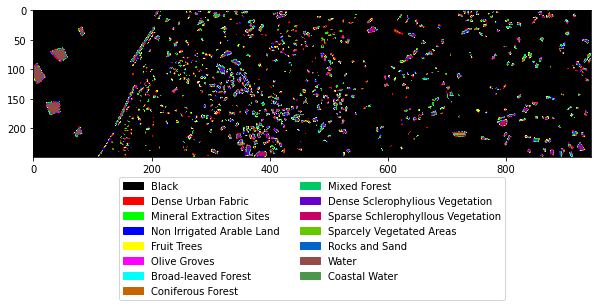

In [36]:
# Show ground-truth image
ground_truth = spectral.imshow(classes = y,figsize =(10,10))

labelDictionary={1:'Dense Urban Fabric', 2:'Mineral Extraction Sites', 3:'Non Irrigated Arable Land', 
                 4:'Fruit Trees', 5:'Olive Groves', 6:'Broad-leaved Forest',7:'Coniferous Forest',
                 8:'Mixed Forest',9:'Dense Sclerophylious Vegetation',10:'Sparse Schlerophyllous Vegetation',
                 11:'Sparcely Vegetated Areas',12:'Rocks and Sand',13:'Water',14:'Coastal Water',0:'Black'}

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=labelDictionary[x]) for x in np.unique(y) ]

plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.1))

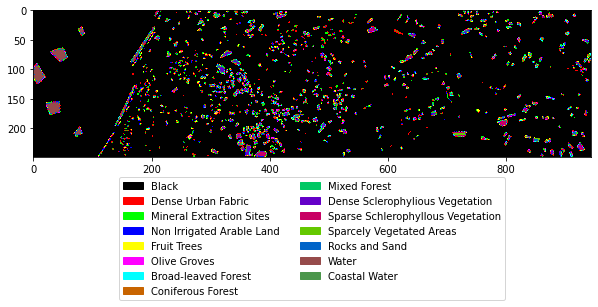

In [37]:
#Show predicted image with no black pixels
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(10,10))

plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.1))

In [38]:
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/ground truth.jpg", y, colors=spectral.spy_colors)

In [39]:
f = open("/content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/classification_report.txt", "r")
print(f.read())

14.001692831516266 Test loss (%)
96.64280414581299 Test accuracy (%)

96.01837282708712 Kappa accuracy (%)
96.64280424586522 Overall accuracy (%)
95.12656016022628 Average accuracy (%)

                                   precision    recall  f1-score   support

               Dense Urban Fabric       0.98      0.95      0.96        86
         Mineral Extraction Sites       1.00      1.00      1.00        20
        Non Irrigated Arable Land       0.97      0.95      0.96       163
                      Fruit Trees       0.95      0.88      0.91        24
                     Olive Groves       0.96      0.98      0.97       420
              Broad-leaved Forest       0.95      0.81      0.87        67
                Coniferous Forest       0.85      0.91      0.88       150
                     Mixed Forest       0.97      0.97      0.97       322
  Dense Sclerophylious Vegetation       0.98      0.96      0.97      1138
Sparse Schlerophyllous Vegetation       0.95      0.97      0.9

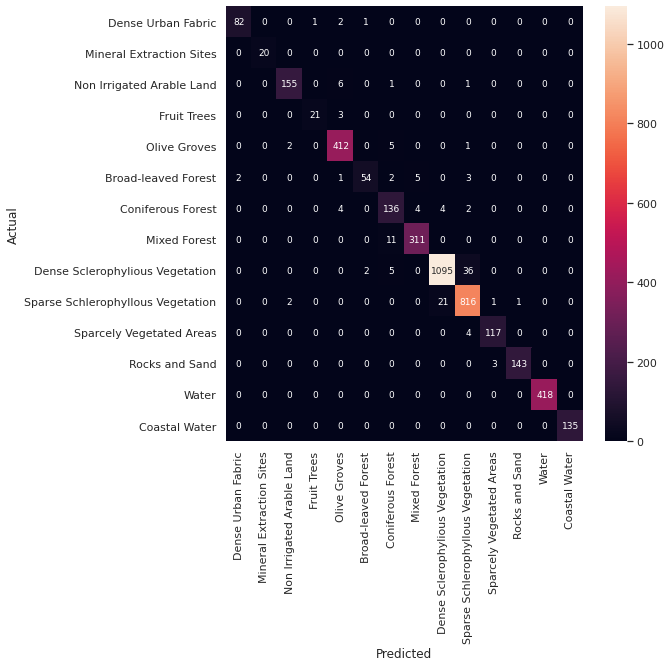

In [40]:
import pandas as pd
import seaborn as sn

names = ['Dense Urban Fabric', 'Mineral Extraction Sites', 'Non Irrigated Arable Land', 'Fruit Trees',
                    'Olive Groves', 
                    'Broad-leaved Forest', 
                    'Coniferous Forest', 
                    'Mixed Forest', 
                    'Dense Sclerophylious Vegetation', 'Sparse Schlerophyllous Vegetation',
                    'Sparcely Vegetated Areas', 'Rocks and Sand', 'Water', 'Coastal Water']

Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)


mat = confusion_matrix(np.argmax(ytest, axis=1), y_pred)

df_cm = pd.DataFrame(mat, columns=names, index = names)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,8))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}, fmt='d')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Different-DL/HyRank/GoogleNet/cmap.png', dpi=300)